# 4.2 DataLoaderの作成

- 本ファイルでは、OpenPosetなど姿勢推定で使用するDatasetとDataLoaderを作成します。MS COCOデータセットを対象とします。

# 学習目標

1.	マスクデータについて理解する
2.	OpenPoseで使用するDatasetクラス、DataLoaderクラスを実装できるようになる
3.	OpenPoseの前処理およびデータオーギュメンテーションで、何をしているのか理解する


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/packages")

In [3]:
cd "/content/drive/My Drive/Colab Notebooks/pytorch_advanced/4_pose_estimation"

/content/drive/My Drive/Colab Notebooks/pytorch_advanced/4_pose_estimation


In [ ]:
# cd "/content/drive/My Drive/Colab Notebooks/pytorch_advanced"

/content/drive/My Drive/Colab Notebooks/pytorch_advanced


In [5]:
# 必要なパッケージのimport
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 画像、マスク画像、アノテーションデータへのファイルパスリストを作成

## ドライブのデータをセッションストレージにコピー

In [17]:
pwd

'/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data'

In [16]:
ls

4-2_DataLoader.ipynb         4-7_OpenPose_inference.ipynb           utils/
4-3-4_NetworkModel.ipynb     data/                                  weights/
4-5_TensorBoardX.ipynb       make_folders_and_data_downloads.ipynb
4-6_OpenPose_training.ipynb  tbX/


In [16]:
cd "/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data"

/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data


In [18]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "/content/data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [46]:
pwd

'/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data'

In [47]:
cd "/content/data"

/content/data


In [48]:
!wget https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz

--2021-03-02 16:34:12--  https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bd9ty7b4fqd5ebf/mask.tar.gz [following]
--2021-03-02 16:34:12--  https://www.dropbox.com/s/raw/bd9ty7b4fqd5ebf/mask.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9e76215020c23b322e88c85e3a.dl.dropboxusercontent.com/cd/0/inline/BJ57CIr86ax-Je_EAvyUN1MwLwmMrKeIIS0PxbRMxv5O3ncOuqg1G-cSSZ32nyJeVei8tRVwSfrAJxk0MWxUHUK0KdC4g5naw7tNIw0Snm0TJw/file# [following]
--2021-03-02 16:34:12--  https://uc9e76215020c23b322e88c85e3a.dl.dropboxusercontent.com/cd/0/inline/BJ57CIr86ax-Je_EAvyUN1MwLwmMrKeIIS0PxbRMxv5O3ncOuqg1G-cSSZ32nyJeVei8tRVwSfrAJxk0MWxUHUK0KdC4g5naw7tNIw0Snm0TJw/file
Resolving uc9e76215

In [76]:
save_path = os.path.join(data_dir, "mask.tar.gz") 
# mask.tar.gzの解凍
with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall(data_dir)

In [44]:
!cp -r "COCO.json" "cowboy-757575_640.jpg" "hit-1407826_640.jpg" "/content/data"

^C


In [14]:
# !cp -r "/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data" "/content"

^C


In [32]:
#rootpath="/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data"
rootpath="/content/data"
osp.join(rootpath, 'COCO.json')

'/content/data/COCO.json'

In [30]:
#!rm -r "/content/data/val2014"

In [50]:
#!rm -r "/content/data/mask"

In [33]:
import os
import urllib.request
import zipfile
import tarfile
data_dir=rootpath
# MSCOCOの2014 Val images [41K/6GB]をダウンロード
# 6GBのダウンロードと解凍なので時間がかかります（10分弱）
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

In [35]:
"""
urllib.request.urlretrieve(url, target_path)

zip = zipfile.ZipFile(target_path)
zip.extractall(data_dir)  # ZIPを解凍
zip.close()  # ZIPファイルをクローズ
"""

In [45]:
"""
save_path = os.path.join(data_dir, "mask.tar.gz") 
with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall(data_dir)
"""

In [52]:
def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータ、マスクデータへのファイルパスリストを作成する。
    """

    # アノテーションのJSONファイルを読み込む
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # indexを格納
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 画像ファイルパスを格納
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        #anno_path = "/content/drive/My Drive/Colab Notebooks/pytorch_advanced/data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        anno_path = "/content/data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "/content/data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [53]:
# 動作確認（実行には10秒ほど時間がかかります）
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath)

val_meta_list[24]


{'annolist_index': 18.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'bbox_other': [[112.24, 245.32, 127.0, 110.76],
  [34.67, 208.02, 91.24, 152.36]],
 'dataset': 'COCO_val',
 'image_id': 488.0,
 'img_height': 406.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [127.0, 311.0, 1.0],
   [170.0, 307.0, 1.0],
   [180.0, 310.0, 1.0],
   [140.0, 341.0, 1.0],
   [148.0, 346.0, 1.0]],
  [[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [106.0, 227.0, 1.0],
   [92.0, 232.0, 1.0],
   [101.0, 232.0, 1.0],
   [0.0, 0.0, 2.0],
   [97.0, 257.0, 1.0],
   [0.0, 0.0, 2.0],
   [94.0, 282.0, 1.0],
   [55.0, 270.0, 1.0],
   [65.0, 271.0, 1.0

# マスクデータの働きを確認

In [22]:
val_img_list[24]

'/content/data/val2014/COCO_val2014_000000000488.jpg'

In [34]:
cv2.imread(val_img_list[24])

array([[[216, 207, 198],
        [217, 208, 199],
        [218, 209, 200],
        ...,
        [234, 224, 217],
        [234, 224, 217],
        [234, 224, 217]],

       [[217, 208, 199],
        [218, 209, 200],
        [218, 209, 200],
        ...,
        [231, 223, 216],
        [230, 222, 215],
        [230, 222, 215]],

       [[218, 209, 200],
        [218, 209, 200],
        [218, 208, 201],
        ...,
        [230, 222, 215],
        [230, 222, 215],
        [230, 222, 215]],

       ...,

       [[ 53,  95, 108],
        [ 64, 106, 119],
        [ 70, 109, 124],
        ...,
        [ 81, 116, 126],
        [ 89, 123, 136],
        [ 73, 106, 121]],

       [[ 85, 124, 138],
        [ 64, 108, 121],
        [ 69, 113, 126],
        ...,
        [ 69, 105, 113],
        [ 97, 132, 142],
        [ 77, 110, 125]],

       [[ 52,  93, 108],
        [ 57, 102, 116],
        [ 74, 122, 134],
        ...,
        [ 58,  93, 103],
        [ 98, 132, 145],
        [ 77, 107, 124]]

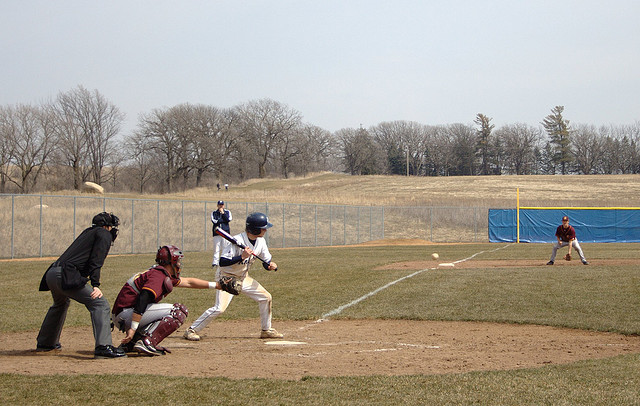

In [41]:
Image.open('/content/data/val2014/COCO_val2014_000000000488.jpg')

In [42]:
val_mask_list[index]

'/content/data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

In [40]:
cv2.imread(val_mask_list[index])

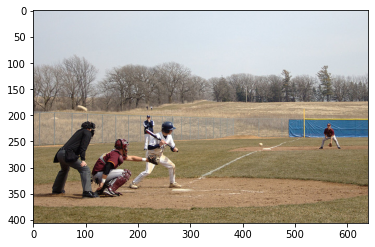

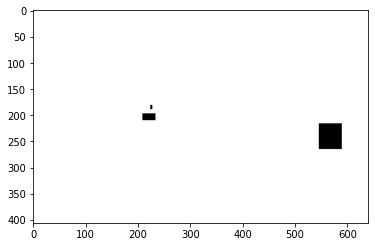

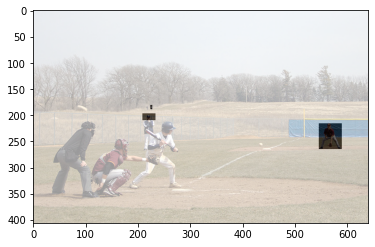

In [54]:
index = 24

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 画像の前処理作成

In [55]:
pwd

'/content/data'

In [11]:
#!cp -r utils ..

In [56]:
# データ処理のクラスとデータオーギュメンテーションのクラスをimportする
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor


class DataTransform():
    """
    画像とマスク、アノテーションの前処理クラス。
    学習時と推論時で異なる動作をする。
    学習時はデータオーギュメンテーションする。
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSONからアノテーションを辞書に格納
                add_neck(),  # アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加
                aug_scale(),  # 拡大縮小
                aug_rotate(),  # 回転
                aug_croppad(),  # 切り出し
                aug_flip(),  # 左右反転
                remove_illegal_joint(),  # 画像からはみ出たアノテーションを除去
                # Normalize_Tensor()  # 色情報の標準化とテンソル化
                no_Normalize_Tensor()  # 本節のみ、色情報の標準化をなくす
            ]),
            'val': Compose([
                # 本書では検証は省略
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss


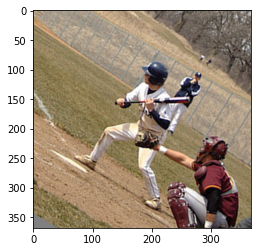

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


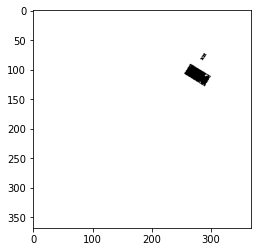

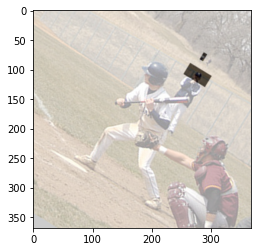

In [57]:
# 動作確認
# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 画像表示
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# マスク表示
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 合成 RGBにそろえてから
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 訓練データの正解情報として使うアノテーションデータの作成

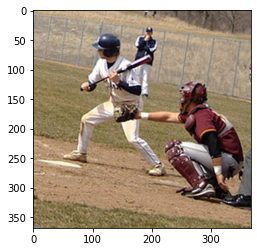

In [58]:
from utils.dataloader import get_ground_truth

# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPoseのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 画像表示
plt.imshow(img)
plt.show()

In [63]:
heat_map

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [67]:
cm.jet(heat_map)

TypeError: ignored

In [61]:
np.uint8(cm.jet(heat_map)*255)

TypeError: ignored

In [73]:
# 左肘のheatmapを確認

# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

In [74]:
# 左手首
heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

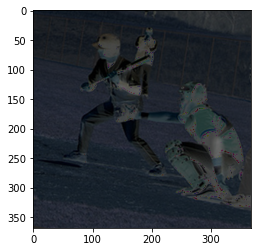

In [68]:
# 左肘と左手首へのPAFを確認
paf = pafs[:, :, 24]  # 24は左肘と左手首をつなぐxベクトルのPAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


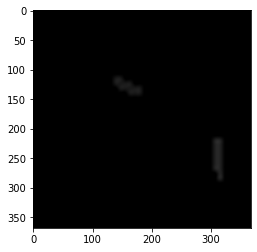

In [69]:
# PAFのみを表示
paf = pafs[:, :, 24]  # 24は左肘と左手首をつなぐxベクトルのPAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)


# Datasetの作成

In [70]:
from utils.dataloader import get_ground_truth


class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCOのCocokeypointsのDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス

    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーション、マスクを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. マスクとアノテーション読み込み
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 画像前処理
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 正解アノテーションデータの取得
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. マスクデータはRGBが(1,1,1)か(0,0,0)なので、次元を落とす
        # マスクデータはマスクされている場所は値が0、それ以外は値が1です
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. チャネルが最後尾にあるので順番を変える
        # 例：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [71]:
# 動作確認
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())


# データの取り出し例
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


# DataLoaderの作成

In [72]:
# データローダーの作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["train"])  # イタレータに変換
item = next(batch_iterator)  # 1番目の要素を取り出す
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


以上